# SETRED
The idea of rewriting the code of the repository is to get a coomprhensive understanding of the SETRED method. 

SETRED stands for self-training with Editing. 

Create a SETRED classifier. It is a self-training algorithm that uses a rejection mechanism to avoid adding noisy samples to the training set. 

The main process are:
1. Train a classifier with the labeled data
2. Create a pool of unalbeled data and select the most confident predictions. 
3. Repeat until the maximum number of iterations is reached. 

    - a. Select the most confident predictions from the unlabeled data. 
    - b. Calculate the neighborhood graph of the labeled data and the selected instances from the unlabeled data. 
    - c. Calculate the significance level of the selected instances (Statistic J_i, sum of cut edges )
    - d. Reject the instances that are not significant according to the statistics J_i.
    - e. Add the selected instances to the labeled data and retrain the classifier. 
    - f. Add new instances to the pool of unalabeled data. 
    
4. Return the classifier trained with the labeled data. 




In [1]:
# Common libraries
import numpy as np 
import pandas as pd 
from scipy.stats import norm 
import os

# Sklearn libraries
# BaseEstimator is a helper class provided by scikit-learn to make it easier to create your own custom models or transformers that behave like 
# any other scikit-learn model. 
# MetaEstimatorMixin is a mixin class from sksklearn.base to help create meta-estimators, which are estimators that wrap other estimators.
from sklearn.base import BaseEstimator, MetaEstimatorMixin, ClassifierMixin
# The clone function creates a new copy of an estimator with the same parameters, but without any trained data, without any fitted attributes. 
from sklearn.base import clone as skclone 
from sklearn.base import is_classifier
from sklearn.ensemble._base import _set_random_states

# Models
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.semi_supervised import SelfTrainingClassifier

# Utils
from sklearn.utils import check_random_state, resample
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.metaestimators import available_if

# Selection classifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    log_loss)

from sklearn.metrics import classification_report

# Simulation functions
from sklearn.datasets import make_classification, make_blobs
from adspy_shared_utilities import plot_class_regions_for_classifier

# Visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Data
from sklearn.datasets import load_iris

# SSlearn library
from sslearn.utils import calculate_prior_probability, check_classifier
from sslearn.model_selection import artificial_ssl_dataset
from sslearn.wrapper import Setred

# SETRED
from setred_package import setred_scratch, simulated_data,  setred_scratch_v2

import inspect

# Simulation

The simulation consists of:

- n: 13000 intances
- classes: 5 labels
- X: design matrix

In [2]:
# Parameters of the simulation
n = 13000  # Number of samples
K = 5      # Number of classes
p = 5     # Number of features

X = np.load("data/X.npy")
y = np.load("data/y.npy")
X_unlabel = np.load("data/X_unlabel.npy")
y_unlabel = np.load("data/y_unlabel.npy")
X_ori = np.load("data/X_ori.npy")
y_ori = np.load("data/y_ori.npy")
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")

In [3]:
colors =    [    '#FF0000',  # Red
    '#00FF00',  # Lime Green
    '#0000FF',  # Blue
    '#800080',  # Purple
    '#00FFFF',  # Cyan / Aqua
    '#FFC0CB',  # Pink
    '#808080',  # Gray
    '#A52A2A',  # Brown
]

cmap_bold = ListedColormap(colors = colors)

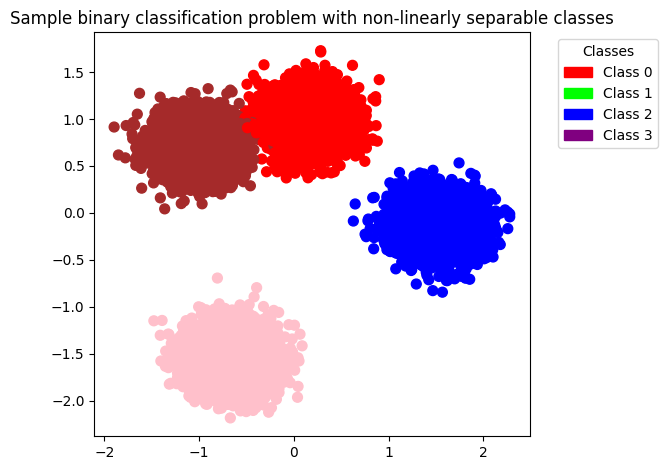

In [4]:
import matplotlib.patches as mpatches
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_ori[:,0], X_ori[:,1], c=y_ori,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_ori)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Artificial semisupervised learning data


In [5]:
# Print the shape of the datasets
print(f"Shape of X: {X.shape}, y: {y.shape}, X_unlabel: {X_unlabel.shape}, y_unlabel: {y_unlabel.shape}")
# Print the number of the classes in y
print(f"Frequencies of classes in y: {pd.Series(y).value_counts(normalize=False)}")


Shape of X: (9750, 2), y: (9750,), X_unlabel: (9653, 2), y_unlabel: (9653,)
Frequencies of classes in y: -1    9653
 3      30
 0      24
 1      24
 2      19
Name: count, dtype: int64


In [6]:
# Filtering the labeled instances
X_val = X[y != -1]
y_val = y[y != -1]
# Print the shape of the validation and testing sets
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y_val and y_test
print(f"Frequencies of classes in y_val: {pd.Series(y_val).value_counts(normalize=False)}")
print(f"Frequencies of classes in y_test: {pd.Series(y_test).value_counts(normalize=False)}")


Shape of X_val: (97, 2), y_val: (97,), X_test: (3250, 2), y_test: (3250,)
Frequencies of classes in y_val: 3    30
0    24
1    24
2    19
Name: count, dtype: int64
Frequencies of classes in y_test: 0    827
3    822
2    820
1    781
Name: count, dtype: int64


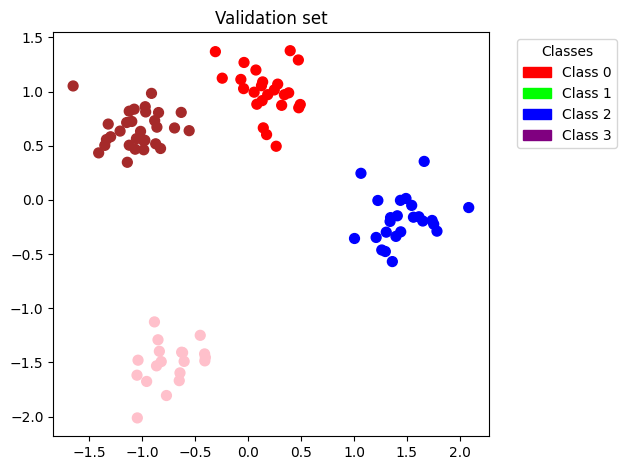

In [7]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_val)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


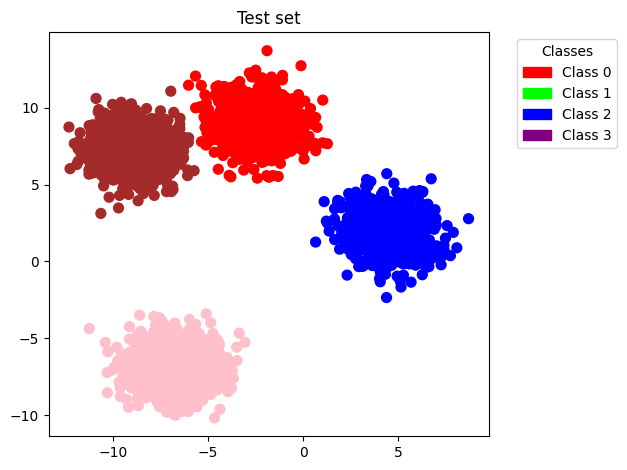

In [8]:
plt.figure()
plt.title('Test set')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_test)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# K nearest neighbours

In [9]:
knn = KNeighborsClassifier()
# Hyperparameters for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9,15,20],
    'weights': ['distance'],
    'p': [2],  # 1 = Manhattan, 2 = Euclidean
    'metric': ['euclidean']
}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_knn = KNeighborsClassifier(**best_params)
base_estimator_knn.fit(X_val, y_val)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}


KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [10]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_knn.predict(X_val)
y_test_pred = base_estimator_knn.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Accuracy of the base estimator on the validation set: 1.0
Accuracy of the base estimator on the test set: 0.9083076923076923
Classification report on validation set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        30

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Classification report on test set:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       827
           1       1.00      0.92      0.96       781
           2       1.00      1.00      1.00       820
           3       0.78      1.00      0.88       822

    accuracy                           0.91      3250
   macro avg       0.92      0.91     

In [11]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_knn.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))

Accuracy of the base estimator on the unlabeled set: 0.9974101315653164
Classification report on unlabeled set:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2399
           1       1.00      1.00      1.00      2445
           2       1.00      1.00      1.00      2411
           3       0.99      1.00      0.99      2398

    accuracy                           1.00      9653
   macro avg       1.00      1.00      1.00      9653
weighted avg       1.00      1.00      1.00      9653



In [12]:
from sklearn.metrics import  accuracy_score
accuracy_score(y_unlabel, y_unlabel_pred,sample_weight=None)

0.9974101315653164

# SETRED CLASSIFIER

In [13]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## KNN SETRED

In [18]:
ssl_clf_knn = setred_scratch.Setred_scratch(base_estimator=base_estimator_knn,
                             graph_neighbors=1,
                             max_iterations=40,                             
                             htunning=True,
                             param_grid={
                                        'n_neighbors': [ 10, 15, 20, 30],
                                        'weights': ['distance', 'uniform'],
                                        'p': [2],  # 1 = Manhattan, 2 = Euclidean
                                        'metric': ['euclidean']
                                            },
                            X_label_real=X_test,
                            y_label_real=y_test,
                            y_unlabel=y_unlabel,
                            view = 1)
ssl_clf_knn.fit(X, y)


Iteration 1 - Accuracy: 1.0000
Iteration 1: Report of the base estimator:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        21

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

Iteration 1 - 167 labeled instances, 9583 unlabeled instances left
Distribution of labels in the labeled set:
0    50
1    47
2    40
3    30
Name: count, dtype: int64
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       827
           1       1.00      0.92      0.96       781
           2       1.00      1.00      1.00       820
           3       0.89      1.00      0.94       822

    accu

Setred_scratch(X_label_real=array([[ -8.55684373,   8.0448222 ],
       [ -7.01012842,  -9.22022379],
       [-10.09432703,   7.70284826],
       ...,
       [ -8.74009415,   7.71467924],
       [  5.30109931,   1.0929912 ],
       [  3.8980863 ,   3.05138373]]),
               base_estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=3,
                                                   weights='distance'),
               graph_neighbors=1, htunning=True,
               param_grid={'metric': ['euclidean'],
                           'n_neighbors': [10, 15, 20, 30], 'p': [2],
                           'weights': ['distance', 'uniform']},
               view=1, y_label_real=array([3, 2, 3, ..., 3, 1, 1]),
               y_unlabel=array([2, 0, 0, ..., 1, 0, 0]))

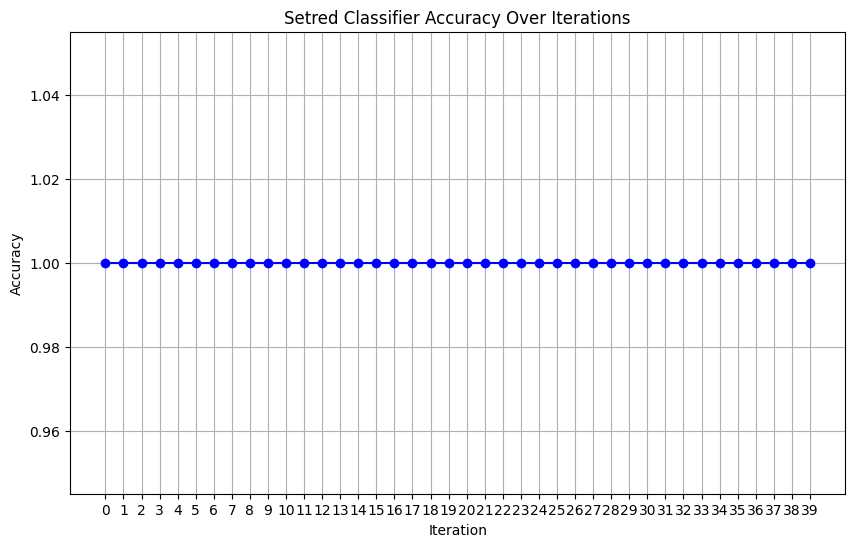

In [19]:
# Plot the accuracy of the Setred classifier
plt.figure(figsize=(10, 6))
plt.plot(ssl_clf_knn.accuracy_, marker='o', linestyle='-', color='b')
plt.title('Setred Classifier Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(len(ssl_clf_knn.accuracy_)))
plt.grid()


# Simulation


In [16]:
# Simulation of the accuracy score
score = []
for i in range(100):
    # Fitting the Setred classifier
    ssl_clf_knn = setred_scratch.Setred_scratch(base_estimator=base_estimator_knn,
                             graph_neighbors=1,
                             max_iterations=20,                             
                             htunning=False,
                             param_grid={
                                        'n_neighbors': [ 10, 15, 20, 30],
                                        'weights': ['distance', 'uniform'],
                                        'p': [2],  # 1 = Manhattan, 2 = Euclidean
                                        'metric': ['euclidean']
                                            },
                            X_label_real=X_test,
                            y_label_real=y_test,
                            y_unlabel=y_unlabel,
                            messages=False,
                            view = 1)
    ssl_clf_knn.fit(X, y)
    # Score
    score.append(ssl_clf_knn.score(X_test, y_test))

Iteration 1 - Accuracy: 1.0000
Iteration 1: Report of the base estimator:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        24

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79

Iteration 2 - Accuracy: 1.0000
Iteration 2: Report of the base estimator:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        26

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74

Iteration 3 - Accuracy: 1.0000
Iteration 3: Report of the base estimator:               pr

KeyboardInterrupt: 

Accuracy score: 0.9741538461538463


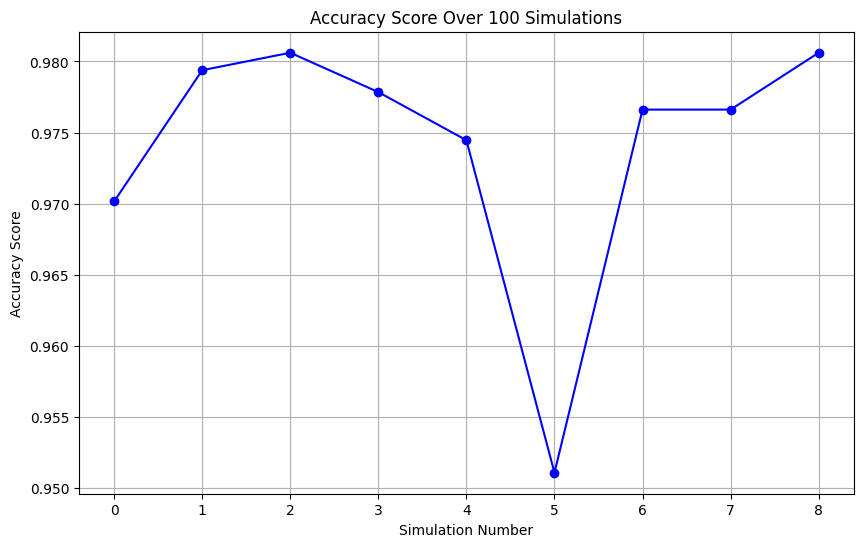

In [20]:
# Display the accuracy score
print(f"Accuracy score: {np.mean(score)}")
# Line plot 
plt.figure(figsize=(10, 6))
plt.plot(score, marker='o', linestyle='-', color='b')
plt.title('Accuracy Score Over 100 Simulations')
plt.xlabel('Simulation Number')
plt.ylabel('Accuracy Score')
plt.grid()
plt.show()

# Evaluation metrics

In [21]:
# Generate predictions on the test set
y_pred = ssl_clf_knn.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       827
           1       1.00      0.94      0.97       781
           2       1.00      1.00      1.00       820
           3       0.99      1.00      0.99       822

    accuracy                           0.98      3250
   macro avg       0.98      0.98      0.98      3250
weighted avg       0.98      0.98      0.98      3250



In [22]:
# Generate predictions on the test set
y_pred = base_estimator_knn.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       827
           1       1.00      0.92      0.96       781
           2       1.00      1.00      1.00       820
           3       0.78      1.00      0.88       822

    accuracy                           0.91      3250
   macro avg       0.92      0.91      0.91      3250
weighted avg       0.92      0.91      0.91      3250



In [23]:
# Generate predictions on the test set
y_pred = ssl_clf_knn.predict(X_unlabel)

# Generate the classification report
report = classification_report(y_unlabel, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2399
           1       1.00      1.00      1.00      2445
           2       1.00      1.00      1.00      2411
           3       1.00      0.98      0.99      2398

    accuracy                           1.00      9653
   macro avg       1.00      1.00      1.00      9653
weighted avg       1.00      1.00      1.00      9653



In [ ]:
X_unlabel = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y_unlabel = np.array([0, 1, 0, 1])

# Resample both together
X_resampled, y_resampled = resample(
    X_unlabel,
    y_unlabel,
    replace=False,
    n_samples=2,
    random_state=42
)
